# Transfer Learning with TPU

## Classify Flowers on TPU

<div align="center">
    <img src="https://steemitimages.com/p/LcTxR7u1XKaa3e4T1EBuBP18JezPvjFFo8gNuE9CiKHBn31rR9T4NmjUUsoAbL1yPkCkAaa9b8ZRqtVUW1YjNvoeQvXGe7A5hyT7XJsyNYcAMhFFnV6LTx2ymSi954PiEQTnJsTzAhCaFQXfzHcPMjnWq?format=match&mode=fit" alt="Spirited Away Flower Garden" style="width: 700px;"> 
</div>
<div align="center">
  © Spirited Away (2001 film)
</div>

First time using a TPU and don't know where to start?

This notebook will take you through the basics of using a **TPU** accelerator and handling TFRecord files. We'll also understand how **transfer learning** works using the ResNet152 V2. And if that's not enough, we'll take things up a notch by implementing **data augmentation** and **fine tuning** our pre-trained model. 

Let's get started!

---

### <font color=''>Table of contents<font><a class='anchor' id='top'></a>

1. [Introduction](#section-one)  
    
2. [Get Data](#section-two)
    
3. [Visualize Data](#section-three)
    
4. [Prepare Data (Optional)](#section-four)
    
5. [Build Model](#section-five)
    
6. [Train Model](#section-six) 

7. [Fine Tune Model (Optional)](#section-seven)
    
8. [Test Model](#secion-eight)
    
9. [Conclusion](#section-nine)

---

<a class="anchor" id="section-one"></a>
## 1. Introduction

This notebook is a great starting point if you want to learn about **Tensor Processing Units** (TPUs). We'll also look at how to load, read and display iamges from **TFRecord** files. Finally, we'll use a fantastic model called the **Residual Network** (ResNet152) to classify different types of flowers.

**How to use this notebook**: If you're new here or you simply want to jump to the results, I recommend skipping the two optional sections. If you're looking to gain a deeper understanding of how the code works, just look for the guides that I wrote. In any case, feel free to play around with the different parameters and settings.

---

<a class="anchor" id="section-two"></a>
## 2. Get Data

* Use try-except block to detect TPU accelerator. If TPU is present, use the accelerator its distribution strategy.
* Get the Google Cloud Storage (GCS) path to retrieve the files.
* Load the TFRecord files and parse the images inside. Two functions are needed for both labeled and unlabeled data.

In [1]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

from kaggle_datasets import KaggleDatasets

2023-02-18 04:55:57.446076: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-18 04:55:57.446136: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### A Guide to TPUs:

In order to detect the TPU accelerator, we need to use a try-except block. It goes like this: try to find TPU cluster to connect to, except when a ValueError occurs, then that means no TPU was found.

If TPU is found in the previous step, we connect the local Tensorflow instance to the TPU cluster. Then, we **initialize** the TPU and create a **distributed training strategy**. If TPU was not found, simply use the training strategy on CPU or GPU.

In [2]:
# Detect TPU, return appropriate distribution strategy

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2023-02-18 04:55:59.263561: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-18 04:55:59.264007: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-18 04:55:59.264048: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-18 04:55:59.264086: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5e4e70ef616b): /proc/driver/nvidia/version does not exist
2023-02-18 04:55:59.265020: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [3]:
# Get GCS path and select the file with 224x224 images

gcs_ds_path = KaggleDatasets().get_gcs_path('tpu-getting-started')
gcs_path = gcs_ds_path + '/tfrecords-jpeg-224x224'

In [4]:
# Set parameters

BUFFER_SIZE = 60000
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [224, 224]
HEIGHT = 224
WIDTH = 224

NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
EPOCHS = 10
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

### A Guide to TFRecords:

TFRecords are simply a more efficient way of **storing** and **transferring** data. Each TFRecord file contains multiple data samples (called examples). Each example stores values for certain features.

Let's look at the code below. Since the TFRecord files are stored in a folder, we need to use the **glob module** to access each individual file. 

Next, TFRecordDataset is used to load these files as bytes. Two dictionaries are created to describe the features for **labeled** and **unlabeled** datasets. We'll create a classes list with all the flower names.

After that, we'll create two functions that will **parse** a single example from a TFRecord file and extract the data contained inside it. We will also **decode** and **resize** the images. Finally, we'll parse the labeled images from the training and validation datasets and parse the unlabeled images from the test dataset.

In [5]:
# Get the path to all the files within the tfrecords-jpeg-224x224 folder

training_filepath = tf.io.gfile.glob(gcs_path + '/train/*.tfrec')
validation_filepath = tf.io.gfile.glob(gcs_path + '/val/*.tfrec')
test_filepath = tf.io.gfile.glob(gcs_path + '/test/*.tfrec') 

2023-02-18 04:56:05.206651: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-18 04:56:05.281204: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-18 04:56:05.350818: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [6]:
# Load TFRecord file from the folder as bytes

raw_training_dataset = tf.data.TFRecordDataset(training_filepath)
raw_validation_dataset = tf.data.TFRecordDataset(validation_filepath)
raw_test_dataset = tf.data.TFRecordDataset(test_filepath)

In [7]:
# Create a dictionary describing the features

labeled_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
}

unlabeled_feature_description = {
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string)
}

In [8]:
# Class name of flowers

CLASSES = [
    'pink primrose',        'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',      'wild geranium',         # 00-04
    'tiger lily',           'moon orchid',               'bird of paradise', 'monkshood',      'globe thistle',         # 05-09
    'snapdragon',           "colt's foot",               'king protea',      'spear thistle',  'yellow iris',           # 10-14
    'globe-flower',         'purple coneflower',         'peruvian lily',    'balloon flower', 'giant white arum lily', # 15-19
    'fire lily',            'pincushion flower',         'fritillary',       'red ginger',     'grape hyacinth',        # 20-24
    'corn poppy',           'prince of wales feathers',  'stemless gentian', 'artichoke',      'sweet william',         # 25-29
    'carnation',            'garden phlox',              'love in the mist', 'cosmos',         'alpine sea holly',      # 30-34
    'ruby-lipped cattleya', 'cape flower',               'great masterwort', 'siam tulip',     'lenten rose',           # 35-39
    'barberton daisy',      'daffodil',                  'sword lily',       'poinsettia',     'bolero deep blue',      # 40-44
    'wallflower',           'marigold',                  'buttercup',        'daisy',          'common dandelion',      # 45-49
    'petunia',              'wild pansy',                'primula',          'sunflower',      'lilac hibiscus',        # 50-54
    'bishop of llandaff',   'gaura',                     'geranium',         'orange dahlia',  'pink-yellow dahlia',    # 55-59
    'cautleya spicata',     'japanese anemone',          'black-eyed susan', 'silverbush',     'californian poppy',     # 60-64
    'osteospermum',         'spring crocus',             'iris',             'windflower',     'tree poppy',            # 65-69
    'gazania',              'azalea',                    'water lily',       'rose',           'thorn apple',           # 70-74
    'morning glory',        'passion flower',            'lotus',            'toad lily',      'anthurium',             # 75-79
    'frangipani',           'clematis',                  'hibiscus',         'columbine',      'desert-rose',           # 80-84
    'tree mallow',          'magnolia',                  'cyclamen ',        'watercress',     'canna lily',            # 85-89
    'hippeastrum ',         'bee balm',                  'pink quill',       'foxglove',       'bougainvillea',         # 90-94
    'camellia',             'mallow',                    'mexican petunia',  'bromelia',       'blanket flower',        # 95-99
    'trumpet creeper',      'blackberry lily',           'common tulip',     'wild rose'                                #100-103
]

In [9]:
# Create a function to read and extract images from dataset

def _parse_labeled_image_function(example_proto):
    example = tf.io.parse_single_example(example_proto, labeled_feature_description)
    image = tf.io.decode_jpeg(example['image'])
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, IMAGE_SIZE)
    label = tf.cast(example['class'], tf.int32)
    return image, label

def _parse_unlabeled_image_function(example_proto):
    example = tf.io.parse_single_example(example_proto, unlabeled_feature_description)
    image = tf.io.decode_jpeg(example['image'])
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, IMAGE_SIZE)
    idnum = example['id']
    return image, idnum

In [10]:
# Parse and extract images

# Parse labeled images, shuffle and batch
training_dataset = (
    raw_training_dataset
    .map(_parse_labeled_image_function)
    .repeat()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Parse unlabeled images and batch
validation_dataset = (
    raw_validation_dataset
    .map(_parse_labeled_image_function)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Parse unlabeled images and batch
test_dataset = (
    raw_test_dataset
    .map(_parse_unlabeled_image_function)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

---

<a class="anchor" id="section-three"></a>
## 3. Visualize Data

* Create a function called display_images and plot the images in a 5x5 grid.

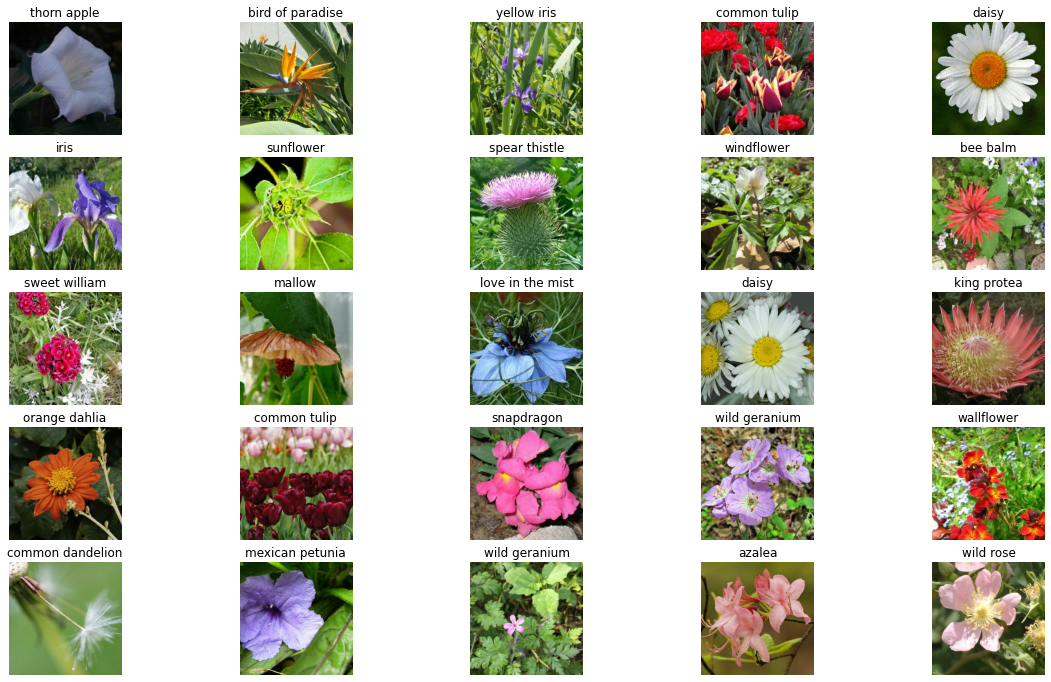

In [11]:
# Display images in a 5x5 grid

image_batch, label_batch = next(iter(training_dataset))

def display_images(image_batch, label_batch):
    plt.figure(figsize = [20,12])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(image_batch[i])
        plt.title(CLASSES[label_batch[i].numpy()])
        plt.axis('off')
    plt.show()

display_images(image_batch, label_batch)

---

<a class="anchor" id="section-four"></a>
## 4. Prepare Data (Optional)

* Perform data augmentation using tf.image to crop, flip and adjust the brightness, contrast and saturation.
* Use the display_images function above to plot images in a 5x5 grid.

### A Guide to Image Augmentation:

This section is entirely optional. Generally, data augmentation does lead to an increase in  the model's performance.

We'll start by creating a function called augment_image. We'll use tf.image to apply **random transformations** to the training set. There are 5 transformations we'll make: **crop, flip, brightness, contrast and saturation**. 

For all of these tf.image functions, you simply need to call the function and apply it to the image. The crop function needs an extra step: you need to resize the image before you can crop it. In the example below, we add 10px to the height and width. 

As for the other tf.image functions, the numbers after the image variable are basically adjustment values. We're increasing brightness by 20% and adjusting contrast and saturation between a range of 80% and 120%.

In [12]:
# Create a function to augment brightness, contrast, flip and crop images

def augment_image(image, label):
    
    # Add 10px padding and random crop
    image = tf.image.resize_with_crop_or_pad(image, HEIGHT+10, WIDTH+10)
    image = tf.image.random_crop(image, size=[*IMAGE_SIZE, 3])
    
    # Random flip
    image = tf.image.random_flip_left_right(image)
    
    # Random brightness
    image = tf.image.random_brightness(image, 0.2)
    
    # Random contrast 
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Random saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    
    return image, label

In [13]:
# Parse unlabeled images, augment, shuffle and batch

training_dataset_augmented = (
    raw_training_dataset
    .map(_parse_labeled_image_function)
    .map(augment_image)
    .repeat()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

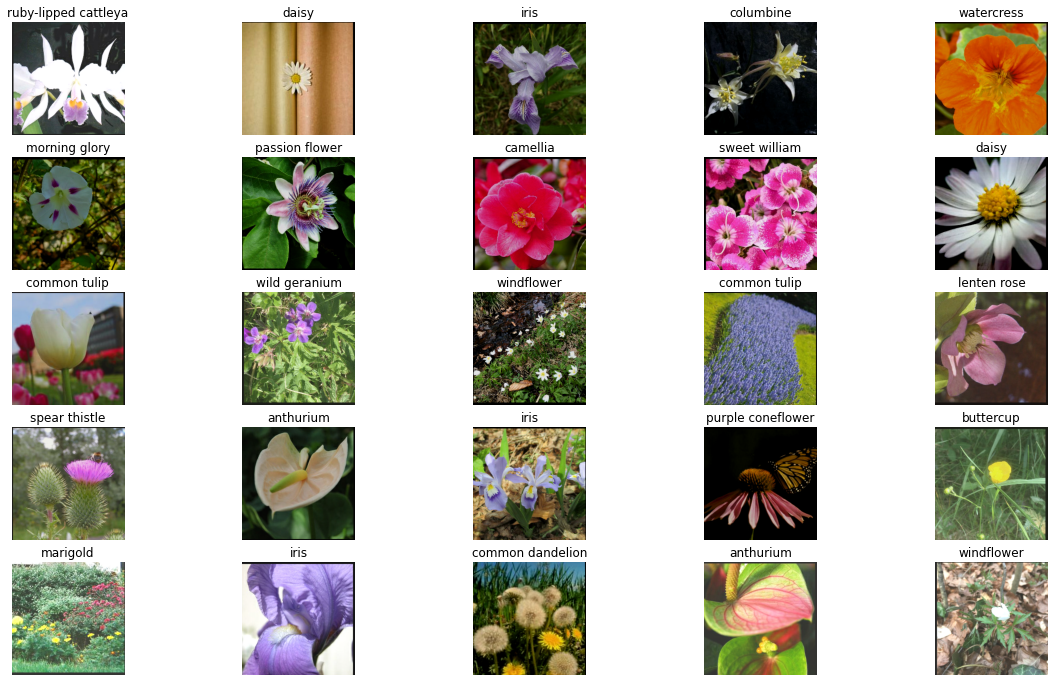

In [14]:
# Display images in a 5x5 grid

image_batch_augmented, label_batch_augmented = next(iter(training_dataset_augmented))

display_images(image_batch_augmented, label_batch_augmented)

---

<a class="anchor" id="section-five"></a>
## 5. Build Model

* Create a function called build_model that uses the ResNet152V2 architecture as the base.
* Freeze the model and add GlobalAveragePooling2D, BatchNormalization, Dropout and Dense layers on top of the base model.
* Compile the new model using the Adam optimizer and sparse categorical cross-entropy loss.

### A Guide to Transfer Learning:

Transfer learning works by taking what a model has learnt on one problem and applying it to another, similar problem. Thankfully, Keras makes it easy for us to use the models that other people created. These models are called **pre-trained models**.

Transfer Learning can be completed in 4 simple steps. First, we need to take the layers from a pretrained model. In the example below, we used the **ResNet152 V2** with pre-trained weights from ImageNet. Also, we did not include the classifier on top. Step 2 is to **freeze the model**. We can simply set trainable to false.

The third step involves adding a few new layers on top. We added a **global average pooling** layer, followed by **batch normalization** and then a **dropout layer**. Right on top of the model, we added a **fully connected** (dense) layer with 104 units (since there are 104 classes of flowers). A softmax activation function is also used here.

Lastly, we need to **compile and train** the new model. We used the adam optimizer and the sparse categorical cross-entropy loss. And that's it! In the next section, we'll proceed to train the model.

In [15]:
# Create a function to build the model

def build_model():
    inputs = Input(shape=(HEIGHT, WIDTH, 3))
    model = ResNet152V2(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = GlobalAveragePooling2D()(model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(104, activation="softmax")(x)

    # Compile
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-2), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["sparse_categorical_accuracy"])
    
    return model

---

<a class="anchor" id="section-six"></a>
## 6. Train Model

* Call the build_model function that was created in the previous section.
* Train the model on the augmented training dataset and test using the validation dataset.

In [16]:
# Train the model

with strategy.scope():
    model = build_model()

hist = model.fit(training_dataset_augmented, 
                 epochs=EPOCHS*2, 
                 validation_data=validation_dataset, 
                 steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/20
99/99 [==============================] - 213s 476ms/step - loss: 2.8889 - sparse_categorical_accuracy: 0.4777 - val_loss: 1.6256 - val_sparse_categorical_accuracy: 0.6150
Epoch 2/20
 3/99 [..............................] - ETA: 5s - loss: 1.4286 - sparse_categorical_accuracy: 0.7014

2023-02-18 05:03:42.184610: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 50991, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1676696622.181332333","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 50991, Output num: 1","grpc_status":3}


99/99 [==============================] - 33s 336ms/step - loss: 1.4382 - sparse_categorical_accuracy: 0.7061 - val_loss: 1.4211 - val_sparse_categorical_accuracy: 0.6802
Epoch 3/20
99/99 [==============================] - 32s 327ms/step - loss: 1.1336 - sparse_categorical_accuracy: 0.7466 - val_loss: 1.2382 - val_sparse_categorical_accuracy: 0.7279
Epoch 4/20
99/99 [==============================] - 30s 307ms/step - loss: 0.8969 - sparse_categorical_accuracy: 0.7831 - val_loss: 1.2849 - val_sparse_categorical_accuracy: 0.7290
Epoch 5/20
99/99 [==============================] - 30s 305ms/step - loss: 0.7514 - sparse_categorical_accuracy: 0.8105 - val_loss: 1.1976 - val_sparse_categorical_accuracy: 0.7468
Epoch 6/20
99/99 [==============================] - 30s 308ms/step - loss: 0.6776 - sparse_categorical_accuracy: 0.8196 - val_loss: 1.1797 - val_sparse_categorical_accuracy: 0.7492
Epoch 7/20
99/99 [==============================] - 29s 300ms/step - loss: 0.6590 - sparse_categorical_acc

---

<a class="anchor" id="section-seven"></a>
## 7. Fine Tune Model (Optional)

* Create a function to unfreeze the top 20 layers of the pretrained model.
* Compile the model using a lower learning rate and train the model.

### A Guide to Fine Tuning:

This section is entirely optional. It can either improve your model or result in overfitting, so you'd definitely need to experiment a'lil with this one!

Once the top layers have been trained, we can try unfreezing a part of the base model and retraining the whole model. In this case, we will **unfreeze the top 20 layers**. 

Take a look at the code right below. We will create a for loop for the top 20 layers and only train the layers that aren't batch normalization layers. You may be wondering why this is the case. That's because **batch normalization** layers contain **non-trainable weights** and when we train those layers, we essentially update those weights which causes the model to lose what it had learnt.

After the for loop, we will compile the model similar to what we did above. The only difference is that we're setting a much **lower learning rate** so as to **prevent overfitting**. Finally, we'll proceed to train the top 20 layers with half the number of epochs compared to the training step above.

In [17]:
# Create a function to unfreeze the model the top 20 layers
# But, we'll keep BatchNormalization layers frozen

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["sparse_categorical_accuracy"])

In [18]:
# Unfreeze and train the model

unfreeze_model(model)

hist = model.fit(training_dataset_augmented, 
                 epochs=EPOCHS, 
                 validation_data=validation_dataset, 
                 steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/10
99/99 [==============================] - 205s 461ms/step - loss: 0.4502 - sparse_categorical_accuracy: 0.8717 - val_loss: 1.1572 - val_sparse_categorical_accuracy: 0.7842
Epoch 2/10
 2/99 [..............................] - ETA: 5s - loss: 0.3692 - sparse_categorical_accuracy: 0.8809

2023-02-18 05:16:42.325045: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 74018, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1676697402.324923732","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 74018, Output num: 1","grpc_status":3}


99/99 [==============================] - 32s 330ms/step - loss: 0.3358 - sparse_categorical_accuracy: 0.8973 - val_loss: 1.0415 - val_sparse_categorical_accuracy: 0.7996
Epoch 3/10
99/99 [==============================] - 31s 317ms/step - loss: 0.2875 - sparse_categorical_accuracy: 0.9112 - val_loss: 1.0882 - val_sparse_categorical_accuracy: 0.7950
Epoch 4/10
99/99 [==============================] - 29s 294ms/step - loss: 0.2428 - sparse_categorical_accuracy: 0.9225 - val_loss: 1.0547 - val_sparse_categorical_accuracy: 0.8017
Epoch 5/10
99/99 [==============================] - 29s 298ms/step - loss: 0.2122 - sparse_categorical_accuracy: 0.9318 - val_loss: 1.0284 - val_sparse_categorical_accuracy: 0.8082
Epoch 6/10
99/99 [==============================] - 29s 299ms/step - loss: 0.1631 - sparse_categorical_accuracy: 0.9469 - val_loss: 1.0531 - val_sparse_categorical_accuracy: 0.8109
Epoch 7/10
99/99 [==============================] - 29s 295ms/step - loss: 0.1557 - sparse_categorical_acc

---

<a class="anchor" id="section-eight"></a>
## 8. Test Model

* Test the model on the test dataset and output the predictions.
* Compile all the predictions together in a file and save it for submission.

In [19]:
# Predict images from test set

test_images = test_dataset.map(lambda image, idnum: image)
prob = model.predict(test_images)
pred = np.argmax(prob, axis=-1)
print(pred)

[67 52 81 ... 14 40 79]


2023-02-18 05:21:40.493452: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 84394, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1676697700.493293194","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 84394, Output num: 0","grpc_status":3}


In [20]:
# Prepare file for submission

test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, pred]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

---

<a class="anchor" id="section-nine"></a>
## 9. Conclusion

If you made it all the way here, congrats! 

In this notebook, we learnt how to use TPUs to **speed up the training** of machine learning models. Next, we looked at how to load and parse images from **TFRecord** files. Finally, we used the pre-trained **ResNet152 V2** model to classify our images, while also tweaking the learning rate and trainable layers.

If you enjoyed this notebook, please consider giving it an upvote. That way, others can discover it too! 

Cheers :)

### References:

* [Use TPUs](https://www.tensorflow.org/guide/tpu)
* [Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)
* [Image classification via fine-tuning with EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#:~:text=Keras%20implementation%20of%20EfficientNet&text=This%20model%20takes%20input%20images,as%20part%20of%20the%20model.)
* [Transfer Learning and Fine Tuning](https://www.tensorflow.org/guide/keras/transfer_learning)
* [Computer Vision - Petals to the Metal](https://www.kaggle.com/code/georgezoto/computer-vision-petals-to-the-metal)